In [2]:
import os,sys,glob
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
import xarray as xr
import pickle 
from math import *
# import warnings

# from scipy.optimize import curve_fit
# from scipy.ndimage import gaussian_filter
# from scipy.signal import argrelextrema


In [4]:
## Add own library to path
workdir = os.getcwd()
repodir = workdir
projectname = 'aggregation-time-scale'
while os.path.basename(repodir) != projectname:
    repodir = os.path.dirname(repodir)
print('repo:',repodir)
thismodule = sys.modules[__name__]
## Own functions
moduledir = os.path.join(repodir,'functions')
sys.path.insert(0,moduledir)
print("Own modules available:", [os.path.splitext(os.path.basename(x))[0]
                                 for x in glob.glob(os.path.join(moduledir,'*.py'))])

repo: /Users/bfildier/Code/analyses/aggregation-time-scale
Own modules available: ['plot2D', 'conditionalstats', 'moistdryedge']


In [16]:
# local input directory
inputdir = os.path.join(repodir,'input','irene')
figdir = os.path.join(repodir,'figures')
moviedir = os.path.join(repodir,'movies')
resultdir = os.path.join(repodir,'results')

## Load own libraries
from moistdryedge import *
# from conditionalstats import *
# from plot2D import *

## Graphical parameters
plt.style.use(os.path.join(matplotlib.get_configdir(),'stylelib/presentation.mplstyle'))

In [8]:
# simname = 'SAM6113_RCE_SST301d1p0r1'
# simname = 'SAM6113_RCE_SST303d1p0r1'
# simname = 'SAM6113_RCE_SST305d1p0r1'
# simname = 'SAM6113_RCE_SST305d2p0r1'
simname = 'SAM6113_RCE_SST307d1p0r1'
print('simname:',simname)

def getDtype(simname):
    return int(simname[-5:-4])

##-- number of processors
if getDtype(simname) == 1:
    nproc = 256
elif getDtype(simname) == 2:
    nproc = 128
    
# get sim-dependent variables
caseid = '_'.join(simname.split('_')[1:])
print('caseid:',caseid)
simdir = os.path.join(inputdir,simname+'.0')
inputfile2D = "%s_%d.2Dcom_1.nc"%(caseid,nproc)
inputpattern3D  = "%s_%d_*.com3D.alltimes.nc"%(caseid,nproc)

simname: SAM6113_RCE_SST307d1p0r1
caseid: RCE_SST307d1p0r1


In [7]:
print('load 2D data')
data2D = xr.open_dataset(os.path.join(simdir,inputfile2D))
time = data2D.time.values

load 2D data


In [14]:
print('load 3D data')
inputpath3D = glob.glob(os.path.join(simdir,inputpattern3D))[0]
data3D = xr.open_dataset(inputpath3D)

load 3D data


In [18]:
print("load edge")

edgevar = 'PW'

file_edge = os.path.join(resultdir,simname,"edge_%s.p"%edgevar)
setattr(thismodule,"edge",pickle.load(open(file_edge,"rb")))

load edge


In [30]:
def deriv(arr,axis=0):

        """Compute derivative of numpy array in argument.
        
        Arguments:
        - arr: numpy array
        - axis: direction
        
        Returns:
        - numpy array of same shape as arr"""
        
        stencil = [1/12,-2/3,0,2/3,-1/12]
        f = lambda x: convolve(x,stencil,mode='wrap')
        
        return np.apply_along_axis(f,axis,arr)

def laplacian2D(arr,dims=(0,1)):
    
    """Returns Laplacian of input array arr."""
    
    return deriv(deriv(arr,axis=dims[0]),axis=dims[0]) + deriv(deriv(arr,axis=dims[1]),axis=dims[1])



2

In [45]:
print("Required data")

ppsfc = data3D.PP.isel(z=0)
pw = data2D.PW

Required data


In [44]:
print('Calculate horizontal Laplacian everywhere')

i_dimx = np.where(np.array(ppsfc.dims) == 'x')[0][0]
i_dimy = np.where(np.array(ppsfc.dims) == 'y')[0][0]

lap_ppsfc = laplacian2D(ppsfc,dims=(i_dimx,i_dimy))

Calculate horizontal Laplacian everywhere


check calculation
0.0


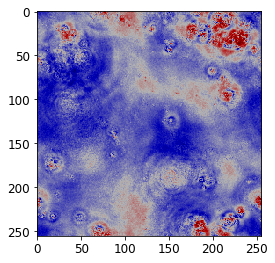

In [94]:
print('check calculation')

i_t = 0

plt.imshow(ppsfc.isel(time=i_t),cmap=plt.cm.seismic)
# plt.show()

thres = edge.edges[i_t].PW_mean
if thres is None:
    mask = np.zeros(pw.isel(time=i_t).shape,dtype=bool)
else:
    mask = pw.isel(time=i_t).values < thres
    

print(mask.sum()/mask.size)

# show border
x = edge.edges[i_t].border_i
y = edge.edges[i_t].border_j
plt.scatter(y,x,marker='o',s=10,color='k')

# show mask
plt.imshow(mask,cmap=plt.cm.Greys_r,alpha=0.3)
plt.show()

In [96]:
x = np.array([[1,2],[3,4]])
m = np.array([[False,False],[True,False]])
x[m]

array([3])

In [97]:
print("Calculate mean of Laplacian in dry patch")

lps_dry = []

for i_t in range(len(time)):
    
    thres = edge.edges[i_t].PW_mean
    if thres is None:
        mask = np.zeros(pw.isel(time=i_t).shape,dtype=bool)
    else:
        mask = np.array(pw.isel(time=i_t).values < thres)
    
    lps_dry.append(np.mean(np.array(ppsfc.isel(time=i_t))[mask]))

lps_dry = np.array(lps_dry)

Calculate mean of Laplacian in dry patch


/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


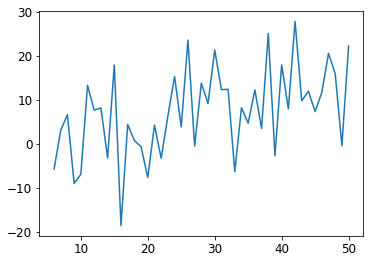

In [98]:
plt.plot(time,lps_dry)